In [7]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
pd.set_option('max_rows', 6)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# import cmocean.cm as cmo
import csv
import statsmodels.api as sm
from scipy import stats

# mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.rm'] = 'serif'

x = "Year CE"
phe = r'$\mathrm{\delta}^{15}$N Phe ('u"\u2030)"
eaa_neaa = ['Phe', 'Thr', 'Ile', 'Leu', 'Val', 'Asx', 'Glx', 'Pro', 'Ala', 'Ser', 'Gly'] # For Essential/Non-Essential ordering
tr_srcaa = ['Glu', 'Asp', 'Ala', 'Ile', 'Leu', 'Pro', 'Val', 'Gly', 'Ser', 'Lys', 'Tyr', 'Phe', 'Thr'] # For Trophic/Source AA ordering
n = r'$\mathrm{\delta}^{15}$N ['u"\u2030]"
c = r'$\mathrm{\delta}^{13}$C ['u"\u2030]"
deg = u'SST [\u00B0C]'

# Import data
path1 = '~/Documents/GitHub/data/schiff_bulk_years_09-04-2019.csv'
path2 = '~/Documents/GitHub/data/schiff_bulk_years_jack4907_12-15-2019.csv'
path3 = '~/Documents/GitHub/data/schiff_bulk_years_sav_12-15-2019.csv'
path4 = '~/Documents/GitHub/data/schiff_bulk_years_stetson_12-15-2019.csv'
path5 = '~/Documents/GitHub/data/schiff_bulk_years_sav_12-22-2019.csv'

df = pd.read_csv(path4, comment = '#')
df.rename(columns={"d15n.vs.air": "d15n", "d13c.vs.vpdb": "d13c", "linear.ad" : "yrAD", "coral.id" : "coral"}, inplace = True)

# Round yrAD column to make things easier
df.yrAD = df.yrAD.round(0)

df_stet = df[df.coral == 'stet-4904-bc1-d2']
# df_jack4907 = df[df.coral == 'jack-4907-bc1-d3']
# df_sav = df[df.coral == 'sav-4902-bc1-unk']
# df_jack4684 = df[df.coral == 'jack-4684-bc-unk']
# df_jack4686 = df[df.coral == 'jack-4686-bc-d1-t1']

print(df)

     Unnamed: 0             coral sampler  sample.no.  distance..mm.  \
0             1  stet-4904-bc1-d2    john           1          0.001   
1             2  stet-4904-bc1-d2    john           2          0.031   
2             3  stet-4904-bc1-d2    john           3          0.061   
..          ...               ...     ...         ...            ...   
383         384  stet-4904-bc1-d2    john         384         11.491   
384         385  stet-4904-bc1-d2    john         385         11.521   
385         386  stet-4904-bc1-d2    john         386         11.551   

         d15n       d13c treatment  perc.n  perc.c  cn.ratio       machine  \
0    9.240000 -16.910000         a     NaN     NaN       NaN           NaN   
1    9.240000 -16.840000         a     NaN     NaN       NaN           NaN   
2    9.630000 -16.910000         b     NaN     NaN       NaN  delta v plus   
..        ...        ...       ...     ...     ...       ...           ...   
383  7.330000 -16.390000         

# Binning time series
This uses a binning function from the Python library Pyleoclim, which is being developed for paleoclimate analysis.

In [4]:
# Using a binning function from Python package Pyleoclim
# Define the function

import numpy as np
import pandas as pd
import warnings
import copy
from scipy import special
import sys
from scipy import signal

def binvalues(x, y, bin_size=None, start=None, end=None):
    """ Bin the values
    Args:
        x (array): the x-axis series.
        y (array): the y-axis series.
        bin_size (float): The size of the bins. Default is the average resolution
        start (float): Where/when to start binning. Default is the minimum
        end (float): When/where to stop binning. Defulat is the maximum
    Returns:
        binned_values - the binned output \n
        bins - the bins (centered on the median, i.e., the 100-200 bin is 150) \n
        n - number of data points in each bin \n
        error -  the standard error on the mean in each bin
    """

    # Make sure x and y are numpy arrays
    x = np.array(x, dtype='float64')
    y = np.array(y, dtype='float64')

    # Get the bin_size if not available
    if bin_size is None:
        bin_size = np.nanmean(np.diff(x))

    # Get the start/end if not given
    if start is None:
        start = np.nanmin(x)
    if end is None:
        end = np.nanmax(x)

    # Set the bin medians
    bins = np.arange(start+bin_size/2, end + bin_size/2, bin_size)

    # Perform the calculation
    binned_values = []
    n = []
    error = []
    for val in np.nditer(bins):
        idx = [idx for idx, c in enumerate(x) if c >= (val-bin_size/2) and c < (val+bin_size/2)]
        if y[idx].size == 0:
            binned_values.append(np.nan)
            n.append(np.nan)
            error.append(np.nan)
        else:
            binned_values.append(np.nanmean(y[idx]))
            n.append(y[idx].size)
            error.append(np.nanstd(y[idx]))

    return bins, binned_values, n, error


## Nitrogen

In [14]:
# Binning
# Jacksonville-4907 BC1
newdf = binvalues(df_jack4907["yrAD"],df_jack4907["d15n"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4907_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4907_binned['upper'] = jack4907_binned['d15n'] + jack4907_binned['Column4']
jack4907_binned['lower'] = jack4907_binned['d15n'] - jack4907_binned['Column4']

In [30]:
# Savannah-4902 BC1
newdf = binvalues(df_sav['yrAD'],df_sav['d15n'], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
sav_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
sav_binned['upper'] = sav_binned['d15n'] + sav_binned['Column4']
sav_binned['lower'] = sav_binned['d15n'] - sav_binned['Column4']

In [5]:
# Binning the Stetson-4904 BC1 data
newdf = binvalues(df_stet['yrAD'],df_stet['d15n'], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
stet_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})

stet_binned['upper'] = stet_binned['d15n'] + stet_binned['Column4']
stet_binned['lower'] = stet_binned['d15n'] - stet_binned['Column4']

In [23]:
print(jack4907_binned)
print(sav_binned)
print(stet_binned)

      yrAD      d15n  Column3   Column4      upper     lower
0  -1128.0  7.836957     23.0  0.573854   8.410810  7.263103
1  -1028.0  7.644348     23.0  0.353895   7.998243  7.290452
2   -928.0  7.938261     23.0  0.272279   8.210540  7.665981
..     ...       ...      ...       ...        ...       ...
22  1072.0  9.803333      3.0  0.254209  10.057542  9.549124
23  1172.0  8.680000      4.0  0.149164   8.829164  8.530836
24  1272.0  9.540000      3.0  0.169902   9.709902  9.370098

[25 rows x 6 columns]
      yrAD      d15n  Column3   Column4      upper     lower
0   -201.0  8.271250      8.0  0.515981   8.787231  7.755269
1   -101.0  8.903333      9.0  0.419073   9.322406  8.484260
2     -1.0  8.397500      8.0  0.488384   8.885884  7.909116
..     ...       ...      ...       ...        ...       ...
14  1199.0  9.650000      3.0  0.679019  10.329019  8.970981
15  1299.0  9.242000      5.0  0.280100   9.522100  8.961900
16  1399.0  8.690000      4.0  0.407615   9.097615  8.282385



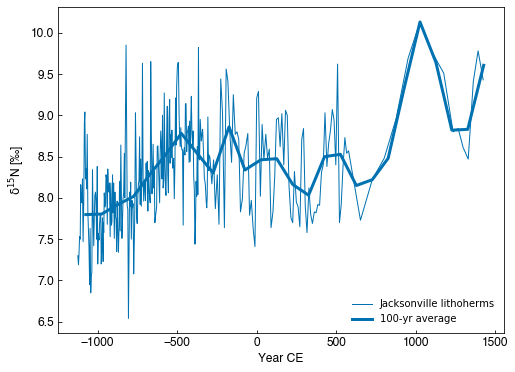

In [19]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4907
data_binned = jack4907_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#0072B2', linewidth = 1, label = 'Jacksonville lithoherms')
ax.plot('yrAD', 'd15n', data=data_binned, color='#0072B2', linewidth = 3, label = '100-yr average')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = False)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_n_jack_binned.png', dpi = 300, bbox_inches = 'tight')

In [8]:
sav_am1 = df_sav

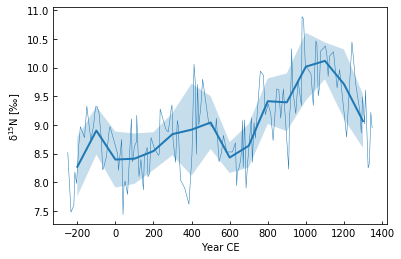

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_sav
data_binned = sav_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd15n', data=data_original, color = '#1f78b4', linewidth = 0.5)
ax.plot('yrAD', 'd15n', data=data_binned, color='#1f78b4', linewidth = 2)
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

ax.fill_between(x, y1, y2, facecolor = '#1f78b4', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE")
ax.set_ylabel(n)

plt.savefig('fig_bulk_n_sav_binned3.png', dpi = 300, bbox_inches = 'tight')

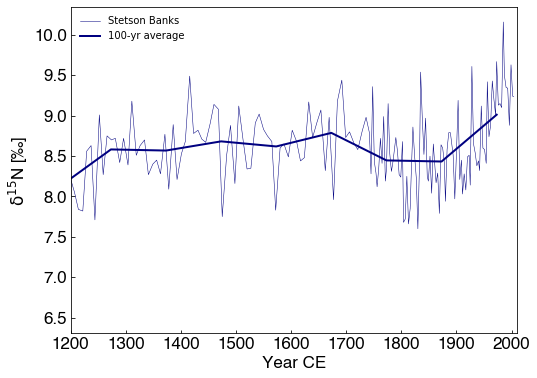

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_stet
data_binned = stet_binned

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

# #D55E00 original color

ax.plot('yrAD', 'd15n', data=data_original, color = 'navy', linewidth = 0.5, label = 'Stetson Banks')
ax.plot('yrAD', 'd15n', data=data_binned, color='navy', linewidth = 2, label = '100-yr average')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 17)
ax.set_ylabel(n, fontname = 'Helvetica', size = 17)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
ax.set_xlim(1200, 2010)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_n_stet_binned.png', dpi = 300, bbox_inches = 'tight')

### Combined Nitrogen

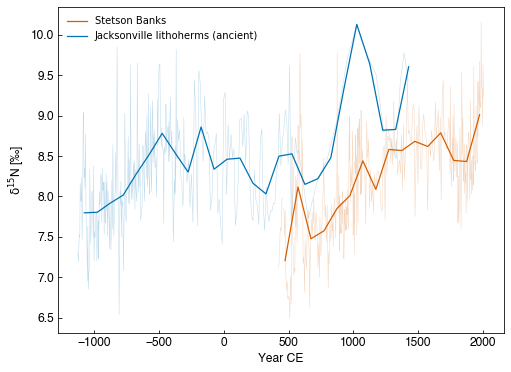

In [21]:
fig, ax = plt.subplots(figsize = (8,6))

# Stetson-4904
x = stet_binned['yrAD']
y1 = stet_binned['upper']
y2 = stet_binned['lower']
ax.plot('yrAD', 'd15n', data=df_stet, color = '#D55E00', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd15n', data=stet_binned, color='#D55E00', linewidth = 1.25, label = 'Stetson Banks')
# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)

# # Savannah-4902 BC1
# x = sav_binned['yrAD']
# y1 = sav_binned['upper']
# y2 = sav_binned['lower']
# ax.plot('yrAD', 'd15n', data=df_sav, color = '#009E73', linewidth = 0.5, label = '', alpha = 0.25)
# ax.plot('yrAD', 'd15n', data=sav_binned, color='#009E73', linewidth = 1.25, label = "Savannah-4902 BC1")
# ax.fill_between(x, y1, y2, facecolor = '#009E73', interpolate = True, alpha = 0.25)

# Jacksonville-4907

x = jack4907_binned['yrAD']
y1 = jack4907_binned['upper']
y2 = jack4907_binned['lower']
ax.plot('yrAD', 'd15n', data=df_jack4907, color = '#0072B2', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd15n', data=jack4907_binned, color='#0072B2', linewidth = 1.25, label = 'Jacksonville lithoherms (ancient)')
# ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(n, fontname = 'Helvetica', size = 12)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.legend(frameon=False, loc=0)

plt.savefig('fig_bulk_n_grouped_binned.png', dpi = 300, bbox_inches='tight')

## Carbon

In [15]:
# d13c
# Jacksonville-4907 BC1
data=df_jack4907
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack_binned_c['upper'] = jack_binned_c['d13c'] + jack_binned_c['Column4']
jack_binned_c['lower'] = jack_binned_c['d13c'] - jack_binned_c['Column4']

In [10]:
# d13c
# Savannah-4902 BC1
data=df_sav
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
sav_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
sav_binned_c['upper'] = sav_binned_c['d13c'] + sav_binned_c['Column4']
sav_binned_c['lower'] = sav_binned_c['d13c'] - sav_binned_c['Column4']

In [6]:
# d13c
# Stetson-4904 BC1
data=df_stet
newdf = binvalues(data["yrAD"],data["d13c"], bin_size = 100)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
stet_binned_c = pd.DataFrame({'yrAD': data[:, 0], 'd13c': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
stet_binned_c['upper'] = stet_binned_c['d13c'] + stet_binned_c['Column4']
stet_binned_c['lower'] = stet_binned_c['d13c'] - stet_binned_c['Column4']

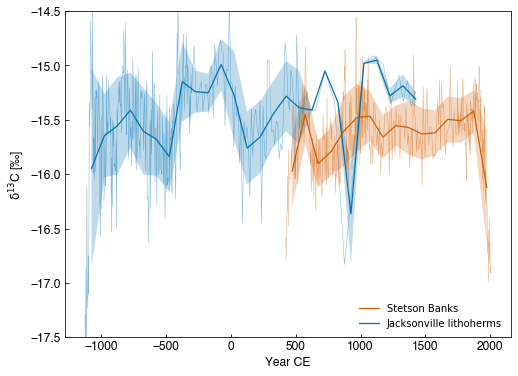

In [20]:
fig, ax = plt.subplots(figsize = (8,6))

# Stetson-4904
x = stet_binned_c['yrAD']
y1 = stet_binned_c['upper']
y2 = stet_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_stet, color = '#D55E00', linewidth = 0.5, alpha = 0.5, label = '')
ax.plot('yrAD', 'd13c', data=stet_binned_c, color='#D55E00', linewidth = 1.25, label = 'Stetson Banks')
ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)

# Jacksonville-4907

x = jack_binned_c['yrAD']
y1 = jack_binned_c['upper']
y2 = jack_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_jack4907, color = '#0072B2', linewidth = 0.5, alpha = 0.5, label = '')
ax.plot('yrAD', 'd13c', data=jack_binned_c, color='#0072B2', linewidth = 1.25, label = 'Jacksonville lithoherms')
ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

# # Savannah-4902 BC1
# x = sav_binned_c['yrAD']
# y1 = sav_binned_c['upper']
# y2 = sav_binned_c['lower']
# ax.plot('yrAD', 'd13c', data=df_sav, color = '#1f78b4', linewidth = 0.5)
# ax.plot('yrAD', 'd13c', data=sav_binned_c, color='#1f78b4', linewidth = 2)
# ax.fill_between(x, y1, y2, facecolor = '#1f78b4', interpolate = True, alpha = 0.25)

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 12)
ax.set_ylabel(c, fontname = 'Helvetica', size = 12)
ax.set_ylim(-17.5, -14.5)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(12)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_jack_stet_ancient.png', dpi = 300, bbox_inches='tight')

In [83]:
stet_binned_c

,yrAD,d13c,Column3,Column4,upper,lower
0,498.0,-15.909734,29.0,0.361206,-15.548528,-16.270939
1,598.0,-15.600000,31.0,0.354383,-15.245617,-15.954383
2,698.0,-15.798750,32.0,0.229371,-15.569379,-16.028121
...,...,...,...,...,...,...
13,1798.0,-15.520800,25.0,0.203429,-15.317371,-15.724229
14,1898.0,-15.466667,27.0,0.276271,-15.190395,-15.742938
15,1998.0,-16.490588,17.0,0.346418,-16.144170,-16.837006


### Stetson Banks bulk d13C record

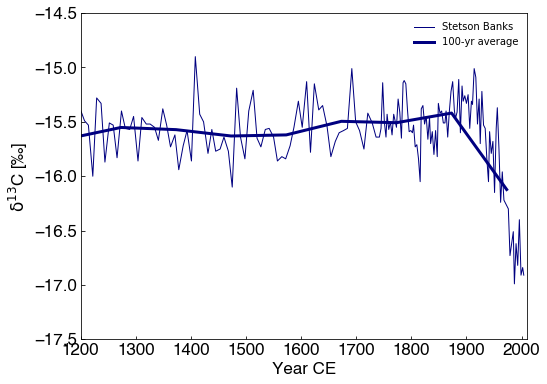

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
data_original = df_stet
data_binned = stet_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

# color: #D55E00

ax.plot('yrAD', 'd13c', data=data_original, color = 'navy', linewidth = 1, label = 'Stetson Banks')
ax.plot('yrAD', 'd13c', data=data_binned, color='navy', linewidth = 3, label = '100-yr average')
# ax.fill_between(x, y1, y2, facecolor = '#D55E00', interpolate = True, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica', size = 17)
ax.set_ylabel(c, fontname = 'Helvetica', size = 17)
ax.set_ylim(-17.5, -14.5)
ax.set_xlim(1200, 2010)

msize = 18
col = '#F0E442'
outline = 'k'
marker = '*'
# plt.plot(data_original['yrAD'][6], data_original['d13c'][6], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][7], data_original['d13c'][7], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][21], data_original['d13c'][21], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][24], data_original['d13c'][24], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][39], data_original['d13c'][39], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][45], data_original['d13c'][45], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][102], data_original['d13c'][102], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][108], data_original['d13c'][108], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][134], data_original['d13c'][134], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)
# plt.plot(data_original['yrAD'][169], data_original['d13c'][169], marker = marker, markerfacecolor = col, markersize = msize, markeredgecolor = outline)

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
    
plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_stet_binned-recent.png', dpi = 300, bbox_inches = 'tight')

In [14]:
data_original

,Unnamed: 0,coral,sampler,sample.no.,distance..mm.,d15n,d13c,treatment,perc.n,perc.c,cn.ratio,machine,X,X.1,yrAD
0,1,stet-4904-bc1-d2,john,1,0.001,9.240000,-16.910000,a,NaN,NaN,NaN,NaN,NaN,NaN,2004
1,2,stet-4904-bc1-d2,john,2,0.031,9.240000,-16.840000,a,NaN,NaN,NaN,NaN,NaN,NaN,2002
2,3,stet-4904-bc1-d2,john,3,0.061,9.630000,-16.910000,b,NaN,NaN,NaN,delta v plus,NaN,NaN,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,384,stet-4904-bc1-d2,john,384,11.491,7.330000,-16.390000,a,NaN,NaN,NaN,delta v plus,NaN,NaN,431
384,385,stet-4904-bc1-d2,john,385,11.521,7.170000,-16.790000,a,NaN,NaN,NaN,delta v plus,NaN,NaN,427
385,386,stet-4904-bc1-d2,john,386,11.551,7.118105,-16.582813,NaN,NaN,NaN,2.95,delta v plus,NaN,NaN,423


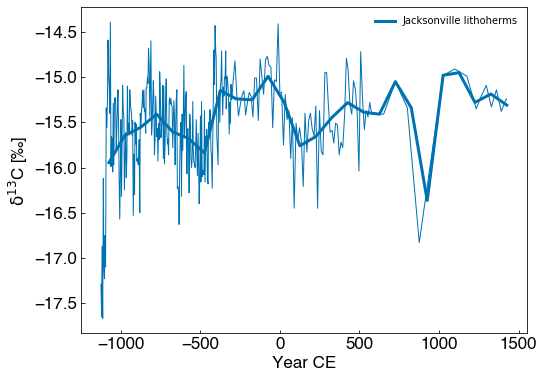

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
data_original = df_jack4907
data_binned = jack_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd13c', data=data_original, color = '#0072B2', linewidth = 1, label = '')
ax.plot('yrAD', 'd13c', data=data_binned, color='#0072B2', linewidth = 3, label = 'Jacksonville lithoherms')
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

# ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = True, alpha = 0.5)

ax.tick_params(direction='in')

ax.set_xlabel("Year CE", size = 17, fontname = 'Helvetica')
ax.set_ylabel(c, size = 17, fontname = 'Helvetica')

# ax.set_xlim(-50, 1400)


for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")
    tick.set_fontsize(17)

plt.legend(frameon=False, loc=0)
plt.savefig('fig_bulk_c_jack_binned3.png', dpi = 300, bbox_inches = 'tight')

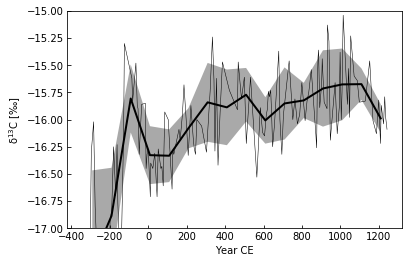

In [127]:
fig, ax = plt.subplots()
data_original = df_sav
data_binned = sav_binned_c

x = data_binned['yrAD']
y1 = data_binned['upper']
y2 = data_binned['lower']

ax.plot('yrAD', 'd13c', data=data_original, color = 'k', linewidth = 0.5)
ax.plot('yrAD', 'd13c', data=data_binned, color='k', linewidth = 2)
# ax.plot(x, y1, x, y2, color = 'darkgray', linewidth=1)

ax.fill_between(x, y1, y2, facecolor = 'darkgray', interpolate = True)

ax.tick_params(direction='in')

ax.set_xlabel("Year CE")
ax.set_ylabel(c)

# ax.set_xlim(-50, 1400)
ax.set_ylim(-17, -15)

# ax.set_xlim(0, max(df_sav['yrAD']))

plt.savefig('fig_bulk_c_sav_binned2.png', dpi = 300, bbox_inches = 'tight')

### Carbon and Nitrogen stacked plot

NameError: name 'jack4907_binned' is not defined

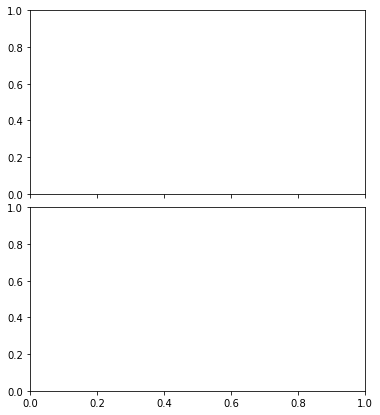

In [15]:
fig, axs = plt.subplots(2, sharex=True, figsize = (6,7), 
                       gridspec_kw={'hspace': 0.075})

binned_n = jack4907_binned
binned_c = jack_binned_c
data_orig = df_jack4907

x = binned_c['yrAD']
y1 = binned_c['upper']
y2 = binned_c['lower']
axs[0].plot('yrAD', 'd13c', data=data_orig, color = '#016c59', linewidth = 0.5, alpha = 0.5)
axs[0].plot('yrAD', 'd13c', data=binned_c, color='#016c59', linewidth = 1.25)
axs[0].fill_between(x, y1, y2, facecolor = '#016c59', interpolate = False, alpha = 0.25)

x = binned_n['yrAD']
y1 = binned_n['upper']
y2 = binned_n['lower']
axs[1].plot('yrAD', 'd15n', data=data_orig, color = '#0072B2', linewidth = 0.5, label = '', alpha = 0.5)
axs[1].plot('yrAD', 'd15n', data=binned_n, color='#0072B2', linewidth = 1.25, label = 'Jacksonville-4907 BC1')
axs[1].fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)

axs[0].set_ylabel(c, fontname = 'Helvetica')
axs[1].set_ylabel(n, fontname = 'Helvetica')
axs[1].set_xlabel('Year CE', fontname = 'Helvetica')

axs[0].set_ylim(-17,-14.5)

axs[0].tick_params(direction='in')
axs[1].tick_params(direction='in')

for tick in axs[0].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[0].get_yticklabels():
    tick.set_fontname("Helvetica")
    
for tick in axs[1].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[1].get_yticklabels():
    tick.set_fontname("Helvetica")

plt.savefig('fig_bulk_jack_combined.png', dpi = 300, bbox_inches='tight')

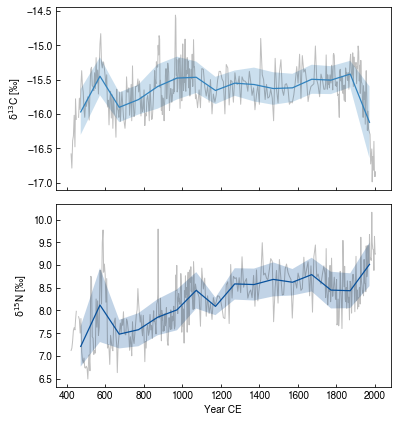

In [30]:
fig, axs = plt.subplots(2, sharex=True, figsize = (6,7), 
                       gridspec_kw={'hspace': 0.075})

binned_n = stet_binned
binned_c = stet_binned_c
data_orig = df_stet

x = binned_c['yrAD']
y1 = binned_c['upper']
y2 = binned_c['lower']
axs[0].plot('yrAD', 'd13c', data=data_orig, color = 'k', linewidth = 1, alpha = 0.25)
axs[0].plot('yrAD', 'd13c', data=binned_c, color='#3182bd', linewidth = 1.25)
axs[0].fill_between(x, y1, y2, facecolor = '#3182bd', interpolate = False, alpha = 0.25)

x = binned_n['yrAD']
y1 = binned_n['upper']
y2 = binned_n['lower']
axs[1].plot('yrAD', 'd15n', data=data_orig, color = 'k', linewidth = 1, alpha = 0.25)
axs[1].plot('yrAD', 'd15n', data=binned_n, color='#08519c', linewidth = 1.25, label = 'Stetson-4904 BC1')
axs[1].fill_between(x, y1, y2, facecolor = '#08519c', interpolate = False, alpha = 0.25)

axs[0].set_ylabel(c, fontname = 'Helvetica')
axs[1].set_ylabel(n, fontname = 'Helvetica')
axs[1].set_xlabel('Year CE', fontname = 'Helvetica')

# axs[0].set_ylim(-17,-14.5)

for tick in axs[0].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[0].get_yticklabels():
    tick.set_fontname("Helvetica")
    
for tick in axs[1].get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in axs[1].get_yticklabels():
    tick.set_fontname("Helvetica")

axs[0].tick_params(direction='in')
axs[1].tick_params(direction='in')

plt.savefig('fig_bulk_stet_combined.png', dpi = 300, bbox_inches='tight')

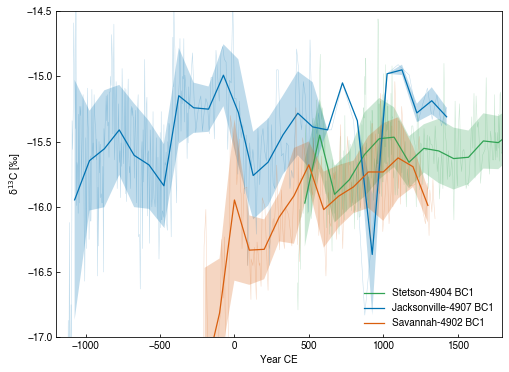

In [54]:
import matplotlib.font_manager as font_manager

fig, ax = plt.subplots(figsize = (8,6))

# Stetson-4904
x = stet_binned_c['yrAD']
y1 = stet_binned_c['upper']
y2 = stet_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_stet, color = '#31a354', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=stet_binned_c, color='#31a354', linewidth = 1.25, label = 'Stetson-4904 BC1')
ax.fill_between(x, y1, y2, facecolor = '#31a354', interpolate = True, alpha = 0.25)

# Jacksonville-4907
x = jack_binned_c['yrAD']
y1 = jack_binned_c['upper']
y2 = jack_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_jack4907, color = '#0072B2', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=jack_binned_c, color='#0072B2', linewidth = 1.25, label = 'Jacksonville-4907 BC1')
ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

# Savannah-4902
x = sav_binned_c['yrAD']
y1 = sav_binned_c['upper']
y2 = sav_binned_c['lower']
ax.plot('yrAD', 'd13c', data=df_sav, color = '#d95f0e', linewidth = 0.5, label = '', alpha = 0.25)
ax.plot('yrAD', 'd13c', data=sav_binned_c, color='#d95f0e', linewidth = 1.25, label = 'Savannah-4902 BC1')
ax.fill_between(x, y1, y2, facecolor = '#d95f0e', interpolate = False, alpha = 0.25)
ax.tick_params(direction='in')

ax.set_xlabel("Year CE", fontname = 'Helvetica')
ax.set_ylabel(c, fontname = 'Helvetica')

for tick in ax.get_xticklabels():
    tick.set_fontname("Helvetica")
for tick in ax.get_yticklabels():
    tick.set_fontname("Helvetica")

ax.set_ylim(-17,-14.5)
ax.set_xlim(-1200,1800)

font = font_manager.FontProperties(family='Helvetica')

plt.legend(frameon=False, loc=0, prop = font)

plt.savefig('fig_bulk_c_grouped_binned.png', dpi = 300, bbox_inches='tight')